In [3]:
import os
import json
import random
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 import

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

## 주요 함수

In [6]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [9]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.map(
        onehot,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds_mixup = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
def history_conv(history):
    
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}
    
    return return_history

## 데이터 준비

In [12]:
BATCH_SIZE = 16

In [13]:
num_classes = ds_info.features["label"].num_classes

In [14]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)

In [15]:
ds_test_all = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=True)

## 모델 준비

In [16]:
def build_model(num_classes):
    base_model = keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg')
    
    output = base_model.output
    
    output = keras.layers.Dense(num_classes, activation='softmax', use_bias=False)(output)
    model = keras.Model(inputs=base_model.input, outputs=output)
    return model

In [17]:
cam_model = build_model(num_classes)

In [18]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## 모델 구성

In [19]:
EPOCH = 50

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.getenv('HOME')+'/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

In [21]:
cam_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cam = cam_model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_all,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/50
750/750 [==============================] - 201s 198ms/step - loss: 2.2170 - accuracy: 0.4482 - val_loss: 3.1214 - val_accuracy: 0.2442

Epoch 00001: val_loss improved from inf to 3.12137, saving model to /aiffel/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5
Epoch 2/50
750/750 [==============================] - 149s 199ms/step - loss: 0.7998 - accuracy: 0.7776 - val_loss: 1.2510 - val_accuracy: 0.6409

Epoch 00002: val_loss improved from 3.12137 to 1.25103, saving model to /aiffel/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5
Epoch 3/50
750/750 [==============================] - 165s 220ms/step - loss: 0.2513 - accuracy: 0.9448 - val_loss: 0.9629 - val_accuracy: 0.7160

Epoch 00003: val_loss improved from 1.25103 to 0.96290, saving model to /aiffel/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_best_val_loss.h5
Epoch 4/50
750/750 [========================

750/750 [==============================] - 149s 199ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 1.0535 - val_accuracy: 0.7444

Epoch 00041: val_loss did not improve from 0.88744
Epoch 42/50
750/750 [==============================] - 149s 199ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.0551 - val_accuracy: 0.7437

Epoch 00042: val_loss did not improve from 0.88744
Epoch 43/50
750/750 [==============================] - 149s 199ms/step - loss: 9.2565e-04 - accuracy: 1.0000 - val_loss: 1.0558 - val_accuracy: 0.7459

Epoch 00043: val_loss did not improve from 0.88744
Epoch 44/50
750/750 [==============================] - 149s 199ms/step - loss: 8.8128e-04 - accuracy: 1.0000 - val_loss: 1.0637 - val_accuracy: 0.7437

Epoch 00044: val_loss did not improve from 0.88744
Epoch 45/50
750/750 [==============================] - 149s 199ms/step - loss: 9.3268e-04 - accuracy: 1.0000 - val_loss: 1.0631 - val_accuracy: 0.7425

Epoch 00045: val_loss did not improve from 0.88744
Epoch

In [22]:
cam_model.save_weights(os.getenv('HOME')+'/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50_last.h5')

In [23]:
cam_model.save(os.getenv('HOME')+'/aiffel/Deep_Dive(CV)_RS10/9_Class_Activation_Map/history/cam_model_resnet50.keras')

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
with open('history/history_resnet50.json', 'w') as f:
    pd.DataFrame(history_resnet50_cam.history).to_json(f)

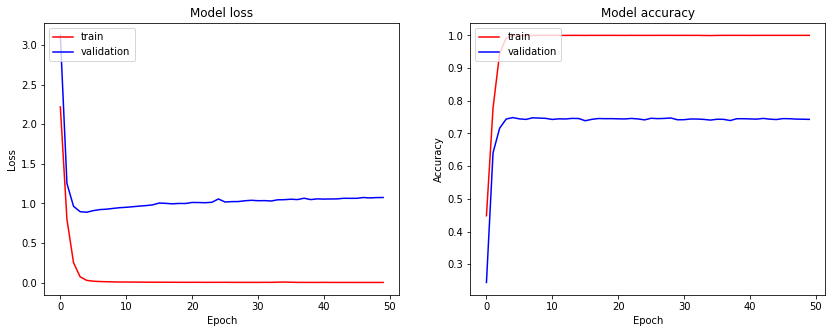

In [26]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(history_resnet50_cam.history['loss'], 'r')
plt.plot(history_resnet50_cam.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history_resnet50_cam.history['accuracy'], 'r')
plt.plot(history_resnet50_cam.history['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()